### Goal

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import scipy.stats as stats
import pandas as pd

import matplotlib.pyplot as plt

### TODO: update this path

In [3]:
root = "/Users/michaelmoret/tinyverse/krap/data/24-12-05/triple/"

### From here; automatic run

In [4]:
for file in os.listdir(root):
    if file.endswith(".txt"):
        print(file)

20241205$25^EN_IHNY_bleached_ELI-1_Phos_control$25^ELI-1*0.01$25^ELI-1*0.03$25^ELI-1*0.05$triple.txt


In [5]:
savepath = f"{root}plots/"
os.makedirs(savepath, exist_ok=True)

In [6]:
all_dfs = []
for file in os.listdir(root):
    if file.endswith(".txt"):
        df = pd.read_csv(root + file, sep="\t")
        splitted_name = file.split("$")
        # get the experiments; i.e. not the date
        # not the single or triple
        splitted_name = splitted_name[1:-1]
        # add the experiment name in the dataframe
        all_names = []
        for entries in splitted_name:
            times_name = entries.split("^")
            _times = int(times_name[0])
            _name = times_name[1]
            all_names += [_name] * _times
        df["Name"] = all_names
        # remove nan
        df = df.dropna()
        all_dfs.append(df)
        
# merge df
df_merged = pd.concat(all_dfs)
df_merged.head(5)

,RECORD,CROSS-SECTIONAL AREA,MEAN DIAMETER,MAX DIAMETER,MIN DIAMETER,ELASTIC EMOD,ELASTIC GRADIENT,ELASTIC EXT,ELASTIC STRESS,PLATEAU LOAD,...,STRESS 25%,WORK 25%,YIELD EXT,POSTYIELD GRADIENT,BREAK EXT,BREAK LOAD,BREAK STRESS,TOTAL WORK,TOUGHNESS,Name
0,1,4828.3,80.5,95.7,64.2,3.617000e+09,59.07,3.58,0.01242,63.39,...,0.01362,0.004322,30.66,4.059,59.12,105.4,0.02183,0.013020,89490000.0,EN_IHNY_bleached_ELI-1_Phos_control
1,2,3954.2,76.8,94.8,53.1,4.387000e+09,58.43,2.58,0.01228,52.06,...,0.01445,0.003823,18.97,1.925,36.88,69.1,0.01747,0.005959,49800000.0,EN_IHNY_bleached_ELI-1_Phos_control
2,3,3592.0,76.0,97.1,47.1,4.339000e+09,52.85,3.03,0.01350,48.42,...,0.01361,0.003415,26.15,3.057,51.20,70.2,0.01954,0.007961,73730000.0,EN_IHNY_bleached_ELI-1_Phos_control
3,4,4177.7,73.9,82.1,64.8,4.079000e+09,56.76,2.78,0.01179,50.15,...,0.01252,0.003610,23.56,2.845,45.10,68.8,0.01647,0.007189,56240000.0,EN_IHNY_bleached_ELI-1_Phos_control
4,5,3738.0,70.2,78.4,60.7,4.130000e+09,52.28,2.86,0.01219,45.81,...,0.01241,0.003225,25.22,2.976,49.44,65.9,0.01763,0.007240,64350000.0,EN_IHNY_bleached_ELI-1_Phos_control


## Helper Functions

In [7]:
import matplotlib.pyplot as plt
import scipy.stats
from itertools import combinations
import numpy as np

def create_boxplot(df, metric_column, group_column='Name', figsize=(10, 6)):
    """Create a compact boxplot with statistical test and median values"""
    
    # Create plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Function to remove outliers
    def remove_outliers(data):
        Q1 = np.percentile(data, 25)
        Q3 = np.percentile(data, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return data[(data >= lower_bound) & (data <= upper_bound)]
    
    # Get unique base names and assign colors
    base_names = [name.split('*')[0] for name in df[group_column].unique()]
    unique_base_names = list(dict.fromkeys(base_names))  # Preserve order
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_base_names)))
    color_dict = dict(zip(unique_base_names, colors))
    
    # Create boxplot
    bp = ax.boxplot([df[df[group_column] == group][metric_column] for group in df[group_column].unique()],
                    patch_artist=True,
                    medianprops={'color': 'red', 'linewidth': 1.5},
                    boxprops={'color': 'black'},
                    whiskerprops={'color': 'black'},
                    capprops={'color': 'black'},
                    showfliers=False)
    
    # Color the boxes
    for patch, group_name in zip(bp['boxes'], df[group_column].unique()):
        base_name = group_name.split('*')[0]
        patch.set_facecolor(color_dict[base_name])
        patch.set_alpha(0.7)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Get unique groups
    group_names = df[group_column].unique()
    
    # Add median values and set x-tick labels
    ax.set_xticklabels(group_names, rotation=45, ha='right')
    
    for i, group in enumerate(group_names):
        median = df[df[group_column] == group][metric_column].median()
        ax.text(i+1, ax.get_ylim()[1]*1.02, f'Median: {round(median, 2)}',
                horizontalalignment='center', fontsize=9)
    
    # Perform pairwise Mann-Whitney U tests
    pairs = list(combinations(group_names, 2))
    
    for group1_name, group2_name in pairs:
        group1_data = df[df[group_column] == group1_name][metric_column]
        group2_data = df[df[group_column] == group2_name][metric_column]
        
        group1_clean = remove_outliers(group1_data)
        group2_clean = remove_outliers(group2_data)
        
        stat, p_value = scipy.stats.mannwhitneyu(group1_clean, group2_clean, alternative='two-sided')
        if p_value < 0.05:
            print(f"Statistical significance between {group1_name} and {group2_name}: p = {p_value:.4f}")
    
    plt.suptitle('')
    plt.title('')
    plt.xlabel(group_column, fontsize=10)
    plt.ylabel(metric_column.replace('_', ' ').title(), fontsize=10)
    ax.yaxis.grid(True, linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    
    return fig, ax

In [8]:
df_merged.columns

Index(['RECORD', 'CROSS-SECTIONAL AREA', 'MEAN DIAMETER', 'MAX DIAMETER',
       'MIN DIAMETER', 'ELASTIC EMOD', 'ELASTIC GRADIENT', 'ELASTIC EXT',
       'ELASTIC STRESS', 'PLATEAU LOAD', 'PLATEAU STRESS', 'LOAD 15%',
       'STRESS 15%', 'WORK 15%', 'LOAD 25%', 'STRESS 25%', 'WORK 25%',
       'YIELD EXT', 'POSTYIELD GRADIENT', 'BREAK EXT', 'BREAK LOAD',
       'BREAK STRESS', 'TOTAL WORK', 'TOUGHNESS', 'Name'],
      dtype='object')

Statistical significance between EN_IHNY_bleached_ELI-1_Phos_control and ELI-1*0.03: p = 0.0167
Statistical significance between EN_IHNY_bleached_ELI-1_Phos_control and ELI-1*0.05: p = 0.0138


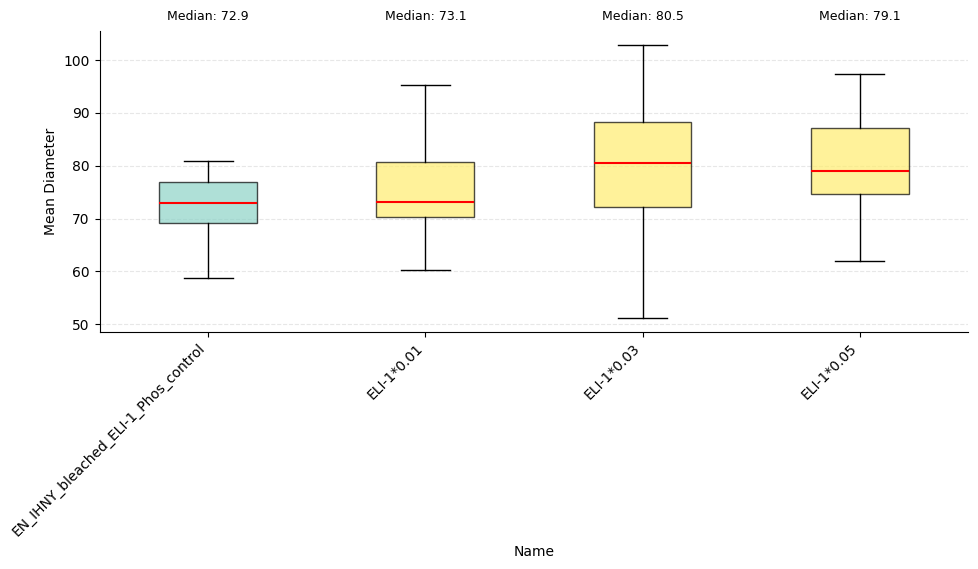

In [9]:
header = 'MEAN DIAMETER'
fig, ax = create_boxplot(df_merged, header)
fig.savefig(f"{savepath}{header}.png")
plt.show()

In [10]:
len(df_merged)

96

Statistical significance between EN_IHNY_bleached_ELI-1_Phos_control and ELI-1*0.05: p = 0.0073


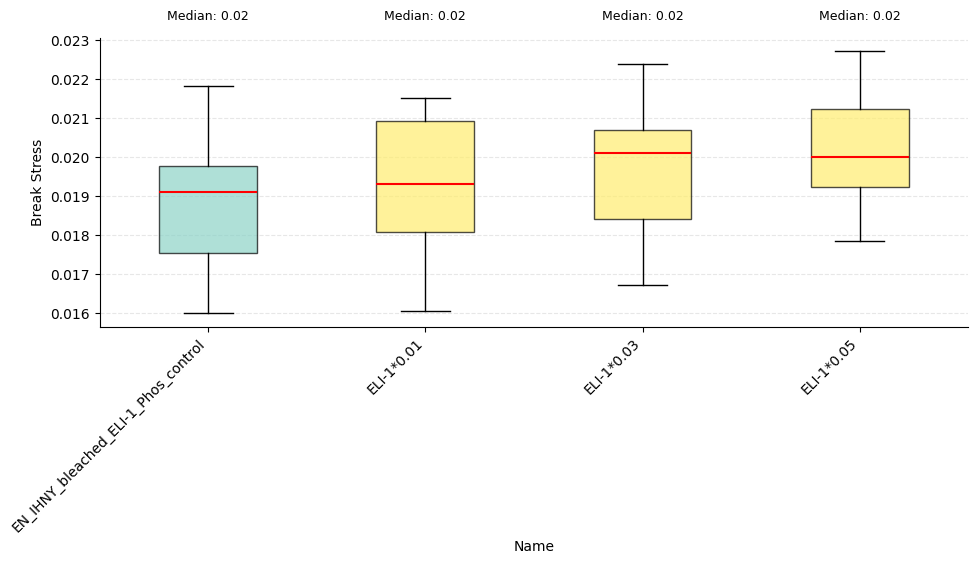

In [11]:
header = 'BREAK STRESS'
fig, ax = create_boxplot(df_merged, header)
fig.savefig(f"{savepath}{header}.png")
plt.show()

Statistical significance between EN_IHNY_bleached_ELI-1_Phos_control and ELI-1*0.05: p = 0.0166


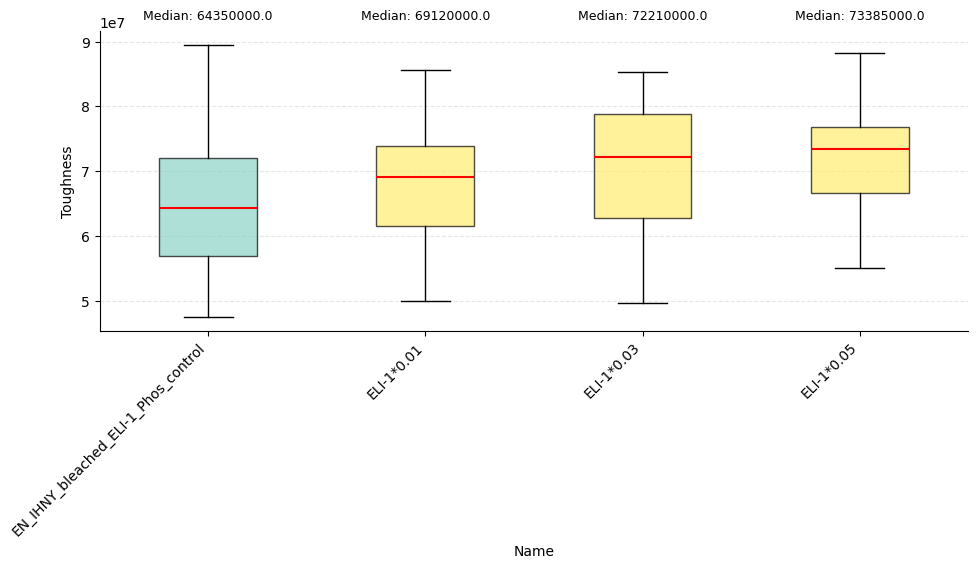

In [12]:
header = 'TOUGHNESS'
fig, ax = create_boxplot(df_merged, header)
fig.savefig(f"{savepath}{header}.png")
plt.show()

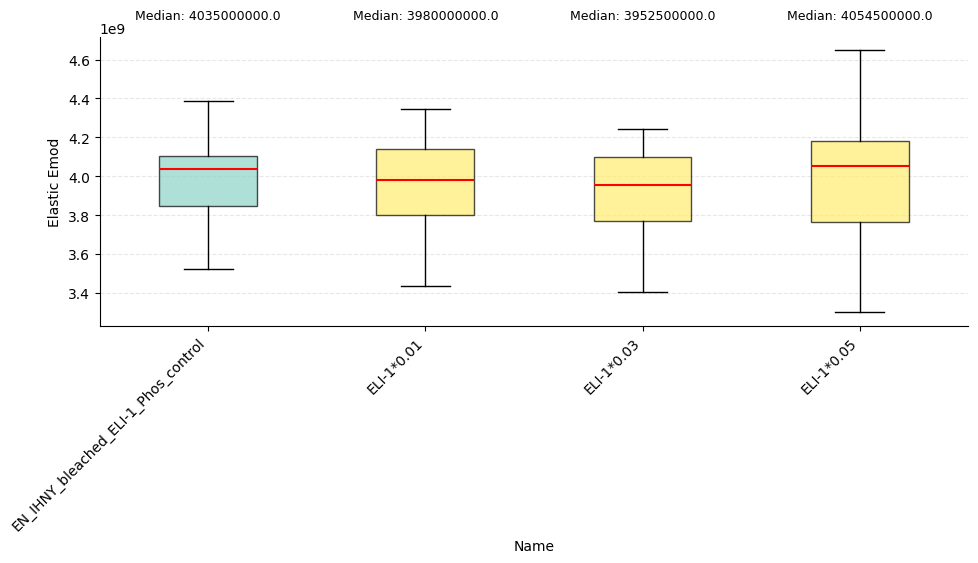

In [13]:
header = 'ELASTIC EMOD'
fig, ax = create_boxplot(df_merged, header)
fig.savefig(f"{savepath}{header}.png")
plt.show()